In this notebook, I will run some toy model simulations just to see if the scaled radial tensor kurtosis proposed by Hansen et al. 2017 (https://pubmed.ncbi.nlm.nih.gov/27539807/) is more robust to implausible negative kurtosis estimates than the standard radial kurtosis estimates (https://pubmed.ncbi.nlm.nih.gov/21337412/).

In [1]:
# Import some relevant DIPY modules

from dipy.sims.voxel import multi_tensor_dki
import dipy.core.gradients as grad
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere
import dipy.reconst.dki as dki
import dipy.reconst.dti as dti
from dipy.reconst.dki import split_dki_param, Wrotate_element
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

Synthetic signals are produced using DIPY (https://www.frontiersin.org/articles/10.3389/fninf.2014.00008/full)

In [2]:
n_pts = 60
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)

In [3]:
bvecs = np.concatenate([np.zeros((5, 3)), hsph_updated.vertices, hsph_updated.vertices])
bvals = np.concatenate([np.zeros((5)), np.ones(hsph_updated.vertices.shape[0]) * 1000., np.ones(hsph_updated.vertices.shape[0]) * 2000.])

In [4]:
gtab= grad.gradient_table(bvals, bvecs)

In [5]:
l1i = ADi =  1.8e-3
l2i = l3i = RDi =  0.03e-3
l1e = ADe =  1.6e-3
l2e = l3e = RDe =  0.6e-3
fie = 60

In [6]:
mevals = np.array([[l1i, l2i, l3i],
                   [l1e, l2e, l3e]])

In [7]:
angles = [(45, 45), (45, 45)]
fractions = [fie, (100 - fie)]

In [8]:
sig_gt, dt, kt = multi_tensor_dki(gtab, mevals, S0=1.0, angles=angles,
                                  fractions=fractions, snr=None)

Standard radial kurtosis estimates are already available in DIPY (c.f. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8327208/)

In [9]:
dkim = dki.DiffusionKurtosisModel(gtab)
dkif = dkim.fit(sig_gt)

In [10]:
RK = dkif.rk(0, 10, analytical=False)

In [11]:
RK

array(3.51433207)

Code to compute the radial tensor kurtosis from DKI fitted model parameters:

In [12]:
def radial_tensor_kurtosis(dki_params, min_kurtosis=-3./7, max_kurtosis=10):
    r""" Compute radial tensor kurtosis (RTK) [1]_

    Parameters
    ----------
    dki_params : ndarray (x, y, z, 27) or (n, 27)
        All parameters estimated from the diffusion kurtosis model.
        Parameters are ordered as follows:
            1) Three diffusion tensor's eigenvalues
            2) Three lines of the eigenvector matrix each containing the first,
               second and third coordinates of the eigenvector
            3) Fifteen elements of the kurtosis tensor
    min_kurtosis : float (optional)
        To keep kurtosis values within a plausible biophysical range, radial
        kurtosis values that are smaller than `min_kurtosis` are replaced with
        `min_kurtosis`. Default = -3./7 (theoretical kurtosis limit for regions
        that consist of water confined to spherical pores [3]_)
    max_kurtosis : float (optional)
        To keep kurtosis values within a plausible biophysical range, radial
        kurtosis values that are larger than `max_kurtosis` are replaced with
        `max_kurtosis`. Default = 10

    Returns
    -------
    rtk : array
        Calculated RK.

    Notes
    -----
    RTK is defined as

    .. math::

    RKT = \frac{3}{8} (W_{2222} + W_{3333} + 2*W_{2233})
    
    where W is the kurtosis tensor rotated to a coordinate system in which the
    3 orthonormal eigenvectors of DT are the base coordinate
    """
    outshape = dki_params.shape[:-1]
    dki_params = dki_params.reshape((-1, dki_params.shape[-1]))

    # Split the model parameters to three variable containing the evals,
    # evecs, and kurtosis elements
    evals, evecs, kt = split_dki_param(dki_params)

    # Rotate the kurtosis tensor from the standard Cartesian coordinate
    # system to another coordinate system in which the 3 orthonormal
    # eigenvectors of DT are the base coordinate
    Wyyyy = Wrotate_element(kt, 1, 1, 1, 1, evecs)
    Wzzzz = Wrotate_element(kt, 2, 2, 2, 2, evecs)
    Wyyzz = Wrotate_element(kt, 1, 1, 2, 2, evecs)

    # Compute RK
    RTK = 3/8 * (Wyyyy +  Wzzzz +  2*Wyyzz)

    if min_kurtosis is not None:
        RTK = RTK.clip(min=min_kurtosis)

    if max_kurtosis is not None:
        RTK = RTK.clip(max=max_kurtosis)

    return RTK.reshape(outshape)

Let's run the radial tensor kurtosis code from the previous fitted DKI model parameters

In [13]:
RKT = radial_tensor_kurtosis(dkif.model_params, -100, 1000)

In [14]:
RKT

array(0.421096)

Radial tensor kurtosis estimates are rescaled to minimize the effects from non radial directions (https://pubmed.ncbi.nlm.nih.gov/27539807/) 

In [15]:
RD = dkif.rd

In [16]:
MD = dkif.md

In [17]:
Kper = RKT * MD**2 / (RD**2)

In [18]:
Kper

3.5143320726714977

Let's now process 10000 instances of signals corrupted by Rician noise with SNR=30

In [21]:
n_sims = 10000
sim_rk = np.empty((n_sims))
sim_kper = np.empty((n_sims))

for sim_idx in range(n_sims):
    sig, dt, kt = multi_tensor_dki(gtab, mevals, S0=1.0, angles=angles,
                                   fractions=fractions, snr=30)
    dkifn = dkim.fit(sig)
    sim_rk[sim_idx] = dkifn.rk(-10, 10)
    rkt_i = radial_tensor_kurtosis(dkifn.model_params, -100, 1000)
    rdi = dkifn.rd
    mdi = dkifn.md
    sim_kper[sim_idx] = rkt_i * mdi**2 / (rdi**2)

Let's now plot the overlaid standard RK and Kper histograms 

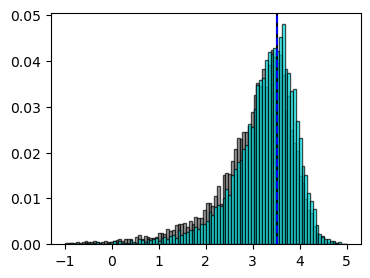

In [22]:
fig1, ax = plt.subplots(1, 1, figsize=(4, 3))
fig1.subplots_adjust(hspace=0.3, wspace=0.15)

counts, ed = np.histogram(sim_rk, bins=100, range=(-1, 5), density=True)
counts = counts/np.sum(counts)
cax0 = ax.bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = 6/100, color='grey', alpha=0.7, edgecolor='black', label='RK (noisy)')

counts, ed = np.histogram(sim_kper, bins=100, range=(-1, 5), density=True)
counts = counts/np.sum(counts)
cax0 = ax.bar(ed[:-1]+np.diff(ed[:2])/2, counts, width = 6/100, color='cyan', alpha=0.7, edgecolor='black',  label='Kper (noisy)')
ax.axvline(x = RK, color = [0, 0, 0], label='K (noise free)')
ax.axvline(x = Kper, linestyle='dashed', color = [0, 0, 1], label='Kper (noise free)')

Indeed, the implausible negagtive kurtosis tail is reduced for Kper estimates.